Wczytanie wyczyszconych danych

In [11]:
import pandas as pd
import numpy as np
import ast

In [28]:
messages = pd.read_csv('../cleaned_datasets/sms_spam.csv', sep='\t', encoding='utf-8')
messages['message_clean_tokens'] = messages['message_clean_tokens'].apply(ast.literal_eval)
messages = messages.dropna(how="any", axis=0)
messages

,label,message,length,message_clean_tokens,message_clean
0,0,"Go until jurong point, crazy.. Available only ...",111,"[go, jurong, point, crazi, avail, bugi, great,...",go jurong point crazi avail bugi great world b...
1,0,Ok lar... Joking wif u oni...,29,"[ok, lar, joke, wif]",ok lar joke wif
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,"[free, entri, wkli, comp, win, fa, cup, final,...",free entri wkli comp win fa cup final tkts may...
3,0,U dun say so early hor... U c already then say...,49,"[dun, say, earli, hor, alreadi, say]",dun say earli hor alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,"[dont, think, goe, usf, live, around, though]",dont think goe usf live around though
...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,"[time, tri, contact, å£, pound, prize, claim, ...",time tri contact å£ pound prize claim easi cal...
5568,0,Will Ì_ b going to esplanade fr home?,37,"[ì, b, go, esplanad, fr, home]",ì b go esplanad fr home
5569,0,"Pity, * was in mood for that. So...any other s...",57,"[piti, mood, soani, suggest]",piti mood soani suggest
5570,0,The guy did some bitching but I acted like i'd...,125,"[guy, bitch, act, like, id, interest, buy, som...",guy bitch act like id interest buy someth els ...


Wizualizacja tokenów

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

wiadomości nie spam

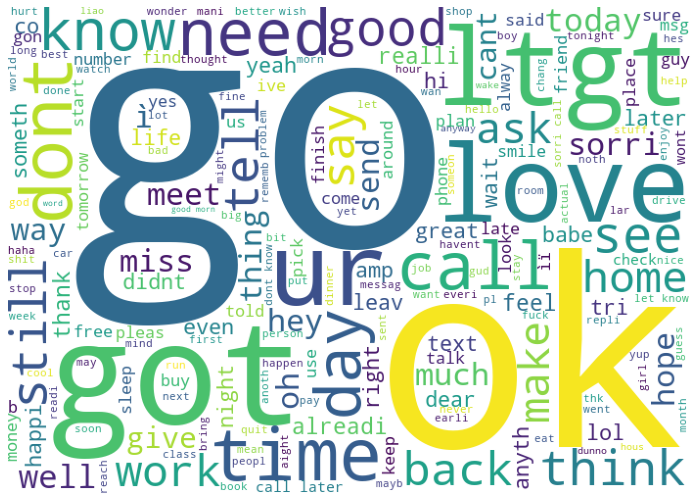

In [14]:
ham_word_cloud = WordCloud(
	width=700,
	height=500,
	background_color='white',
)
ham_word_cloud.generate(' '.join(text for text in messages.loc[messages['label'] == 0, 'message_clean']))
plt.figure(figsize=(15, 9))
plt.axis("off")
plt.imshow(ham_word_cloud)
plt.show()

wiadomości spam

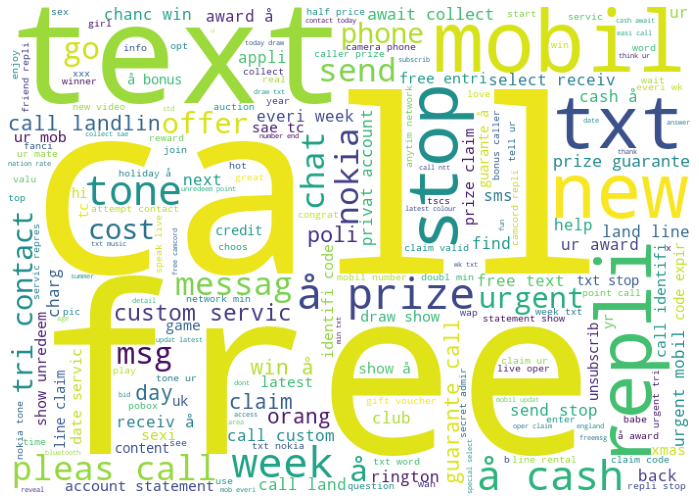

In [15]:
spam_word_cloud = WordCloud(
	width=700,
	height=500,
	background_color='white',
)
spam_word_cloud.generate(' '.join(text for text in messages.loc[messages['label'] == 1, 'message_clean']))
plt.figure(figsize=(15, 9))
plt.axis("off")
plt.imshow(spam_word_cloud)
plt.show()

Wektoryzacja

In [16]:
x = messages['message_clean']
y = messages['label']

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, stratify=y, random_state=1337)

count_vectorizer = CountVectorizer(
	stop_words='english',
	ngram_range=(1, 2),
	max_features=100
)

x_train_count_matrix = count_vectorizer.fit_transform(x_train)
x_test_count_matrix = count_vectorizer.transform(x_test)

In [18]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

x_train_tfidf = tfidf_transformer.fit_transform(x_train_count_matrix)
x_test_tfidf = tfidf_transformer.transform(x_test_count_matrix)

Padding wektorów

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(messages['message_clean'])

In [20]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_messages = pad_sequences(
	word_tokenizer.texts_to_sequences(x),
	padding='post'
)

In [21]:
max_padded_len = padded_messages.shape[1]
padded_messages

array([[   2, 3100,  257, ...,    0,    0,    0],
       [   7,  221,  501, ...,    0,    0,    0],
       [   9,  338,  556, ...,    0,    0,    0],
       ...,
       [6632,  956, 6633, ...,    0,    0,    0],
       [ 126, 1196, 1545, ...,    0,    0,    0],
       [1921,  358,    0, ...,    0,    0,    0]])

GloVe

In [22]:
embeddings_dictionary = dict()
embedding_dim = 100

with open('../glove/glove.6B.100d.txt', encoding='utf8') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions

Modelowanie

In [23]:
# multinomial bayes

from sklearn.naive_bayes import MultinomialNB
multinomial_nb = MultinomialNB()
multinomial_nb.fit(x_train_count_matrix, y_train)
y_pred_class = multinomial_nb.predict(x_test_count_matrix)
y_pred_prob = multinomial_nb.predict_proba(x_test_count_matrix)[:, 1]

In [24]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))
metrics.confusion_matrix(y_test, y_pred_class)

0.9531953195319532


array([[944,  18],
       [ 34, 115]], dtype=int64)

In [25]:
# svm
from sklearn import svm
svm = svm.SVC()
svm.fit(x_train_count_matrix, y_train)
y_pred_class = svm.predict(x_test_count_matrix)
print(metrics.accuracy_score(y_test, y_pred_class))

0.9576957695769577
